<a href="https://colab.research.google.com/github/Iallen520/lhy_DL_Hw/blob/master/hw13_meta_omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HW13 Meta Learning: Omniglot Few-Shot Classification**
目標：reproduce Finn 的實驗結果

手把手影片：https://drive.google.com/open?id=1DjwXTpEVK__f5dmlkU4kUgaaTmFtHfIw

手把手投影片：https://drive.google.com/open?id=1FUVULNb8LwTt8Ixs3vra6poGeRcOap4n

#####**在你看這裡時，請你先執行 step 1 下載資料第一個、第二個 block 的程式碼，再繼續往下看。**
Reference: 
1. A repo containing lots of few-shot learning models: https://github.com/oscarknagg/few-shot
2. A pytorch implementation: https://github.com/dragen1860/MAML-Pytorch
3. The official Tf implementation: https://github.com/cbfinn/maml
4. Omniglot dataset: https://github.com/brendenlake/omniglot

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com


## **Step 1: 下載資料**

首先我們要把 Omniglot 的 dataset 下載下來。這裡下載的都是助教已經處理過，並且做過 data augmentation 的資料。

In [0]:
workspace_dir = '.'
# gdown 是一個可以從 google drive 下載資料的工具
!gdown --id 1UyIXE8p3Se__xUAYE6dYjkae95_Bc7xQ --output "{workspace_dir}/Omniglot.tar.gz"




Downloading...
From: https://drive.google.com/uc?id=1UyIXE8p3Se__xUAYE6dYjkae95_Bc7xQ
To: /content/Omniglot.tar.gz
36.1MB [00:01, 32.3MB/s]


接著我們把 dataset 的檔案解壓縮
因為檔案非常大，要等一下子，可以先執行解壓縮，同時看一下 model 的部分程式


In [0]:
#!tar -zxvf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"  #這行會印出解壓縮的所有檔案，因為很煩所以我註解掉了
!tar -zxf "{workspace_dir}/Omniglot.tar.gz" -C "{workspace_dir}/"   #這行在解壓縮時不會印檔案名稱出來

我們看一下 Omniglot 的 dataset 長什麼樣子


In [0]:
from PIL import Image
from IPython.display import display
for i in range(10, 20):
  im = Image.open("Omniglot/images_background/Japanese_(hiragana).0/character13/0500_" + str (i) + ".png")
  display(im)

## **Step 2: 建立模型**
以下我們就要開始建立核心的 MAML 模型
首先我們將需要的套件引入

In [0]:
# Import modules we need
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import glob
from tqdm import tqdm
import numpy as np
from collections import OrderedDict

接著我們要建立一個 nn.Module，作為 omniglot 的分類器(Classifier)
我們使用的是 CNN-based 的分類器。
以下是 MAML 的演算法:
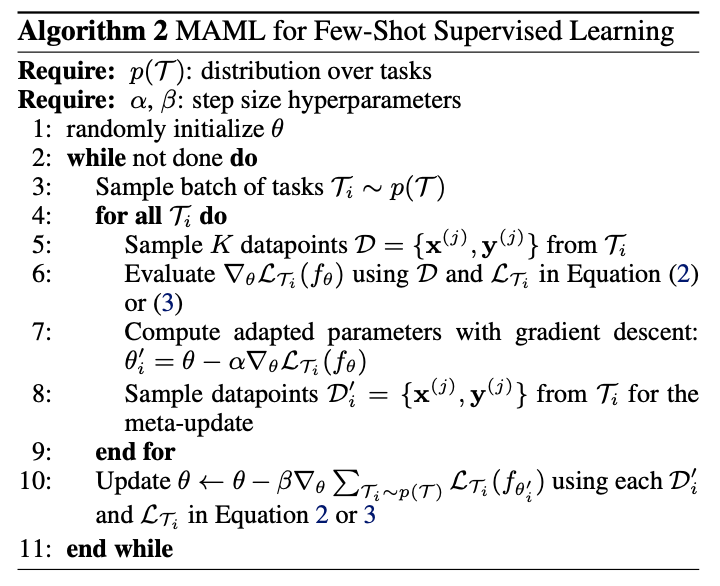

由於在第10行，我們是要對原本的參數 θ 微分，並非 inner-loop (Line5~8) 的 θ' 微分，因此在 inner-loop，我們需要用 functional forward 的方式算出 input image 的 output logits，而不是直接用 nn.module 裡面的 forward（直接對 θ 微分）。在下面我們分別定義了 functional forward 以及 forward 函數。


In [0]:
def ConvBlock(in_ch, out_ch):
  return nn.Sequential(nn.Conv2d(in_ch, out_ch, 3, padding = 1),
                       nn.BatchNorm2d(out_ch),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size = 2, stride = 2)) # 原作者在 paper 裡是說她在 omniglot 用的是 strided convolution
                                                                  # 不過這裡我改成 max pool (mini imagenet 才是 max pool)
                                                                  # 這並不是你們在 report 第三題要找的 tip
def ConvBlockFunction(x, w, b, w_bn, b_bn):
  x = F.conv2d(x, w, b, padding = 1)
  x = F.batch_norm(x, running_mean = None, running_var = None, weight = w_bn, bias = b_bn, training = True)
  x = F.relu(x)
  x = F.max_pool2d(x, kernel_size = 2, stride = 2)
  return x

class Classifier(nn.Module):
  def __init__(self, in_ch, k_way):
    super(Classifier, self).__init__()
    self.conv1 = ConvBlock(in_ch, 64)
    self.conv2 = ConvBlock(64, 64)
    self.conv3 = ConvBlock(64, 64)
    self.conv4 = ConvBlock(64, 64)
    self.logits = nn.Linear(64, k_way)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = nn.Flatten(x)
    x = self.logits(x)
    return x

  def functional_forward(self, x, params):
    '''
    Arguments:
    x: input images [batch, 1, 28, 28]
    params: 模型的參數，也就是 convolution 的 weight 跟 bias，以及 batchnormalization 的  weight 跟 bias
            這是一個 OrderedDict
    '''
    for block in [1, 2, 3, 4]:
      x = ConvBlockFunction(x, params[f'conv{block}.0.weight'], params[f'conv{block}.0.bias'],
                            params.get(f'conv{block}.1.weight'), params.get(f'conv{block}.1.bias'))
    x = x.view(x.shape[0], -1)
    x = F.linear(x, params['logits.weight'] , params['logits.bias'])
    return x


這個函數是用來產生 label 的。在 n_way, k_shot 的 few-shot classification 問題中，每個 task 會有 n_way 個類別，每個類別k_shot張圖片。這是產生一個 n_way, k_shot 分類問題的 label 的函數


In [0]:
def create_label(n_way, k_shot):
  return torch.arange(n_way).repeat_interleave(k_shot).long()
  
# 我們試著產生 5 way 2 shot 的 label 看看
create_label(5, 2)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4])

接下來這裡是 MAML 的核心。演算法就跟原文完全一樣，這個函數做的事情就是用 "一個 meta-batch的 data" 更新參數。這裡助教實作的是二階MAML(inner_train_step = 1)，對應老師投影片 meta learning p.13~p.18。如果要找一階的數學推導，在老師投影片 p.25。


(http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2019/Lecture/Meta1%20(v6).pdf)

以下詳細解釋：




In [0]:
def MAML(model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 1, inner_lr = 0.4, train = True):
  """
  Args:
  x is the input omniglot images for a meta_step, shape = [batch_size, n_way * (k_shot + q_query), 1, 28, 28]
  n_way: 每個分類的 task 要有幾個 class
  k_shot: 每個類別在 training 的時候會有多少張照片
  q_query: 在 testing 時，每個類別會用多少張照片 update
  """
  criterion = loss_fn
  task_loss = [] # 這裡面之後會放入每個 task 的 loss 
  task_acc = []  # 這裡面之後會放入每個 task 的 loss 
  for meta_batch in x:
    train_set = meta_batch[:n_way*k_shot] # train_set 是我們拿來 update inner loop 參數的 data
    val_set = meta_batch[n_way*k_shot:]   # val_set 是我們拿來 update outer loop 參數的 data
    
    fast_weights = OrderedDict(model.named_parameters()) # 在 inner loop update 參數時，我們不能動到實際參數，因此用 fast_weights 來儲存新的參數 θ'
    
    for inner_step in range(inner_train_steps): # 這個 for loop 是 Algorithm2 的 line 7~8
                                                # 實際上我們 inner loop 只有 update 一次 gradients，不過某些 task 可能會需要多次 update inner loop 的 θ'，
                                                # 所以我們還是用 for loop 來寫
      train_label = create_label(n_way, k_shot).cuda()
      logits = model.functional_forward(train_set, fast_weights)
      loss = criterion(logits, train_label)
      grads = torch.autograd.grad(loss, fast_weights.values(), create_graph = True) # 這裡是要計算出 loss 對 θ 的微分 (∇loss)    
      fast_weights = OrderedDict((name, param - inner_lr * grad)
                                  for ((name, param), grad) in zip(fast_weights.items(), grads)) # 這裡是用剛剛算出的 ∇loss 來 update θ 變成 θ'
  
    val_label = create_label(n_way, q_query).cuda()
    logits = model.functional_forward(val_set, fast_weights) # 這裡用 val_set 和 θ' 算 logit
    loss = criterion(logits, val_label)                      # 這裡用 val_set 和 θ' 算 loss
    task_loss.append(loss)                                   # 把這個 task 的 loss 丟進 task_loss 裡面
    acc = np.asarray([torch.argmax(logits, -1).cpu().numpy() == val_label.cpu().numpy()]).mean() # 算 accuracy
    task_acc.append(acc)
    
  model.train()
  optimizer.zero_grad()
  meta_batch_loss = torch.stack(task_loss).mean() # 我們要用一整個 batch 的 loss 來 update θ (不是 θ')
  if train:
    meta_batch_loss.backward()
    optimizer.step()
  task_acc = np.mean(task_acc)
  return meta_batch_loss, task_acc

定義 dataset。這個 dataset 會回傳某個 character 的 image，總共會有 k_shot+q_query 張，所以回傳的 tensor 大小是 [k_shot+q_query, 1, 28, 28]

In [0]:
class Omniglot(Dataset):
  def __init__(self, data_dir, k_way, q_query):
    self.file_list = [f for f in glob.glob(data_dir + "**/character*", recursive=True)]
    self.transform = transforms.Compose([transforms.ToTensor()])
    self.n = k_way + q_query
  def __getitem__(self, idx):
    sample = np.arange(20)
    np.random.shuffle(sample) # 這裡是為了等一下要 random sample 出我們要的 character
    img_path = self.file_list[idx]
    img_list = [f for f in glob.glob(img_path + "**/*.png", recursive=True)]
    img_list.sort()
    imgs = [self.transform(Image.open(img_file)) for img_file in img_list]
    imgs = torch.stack(imgs)[sample[:self.n]] # 每個 character，取出 k_way + q_query 個
    return imgs
  def __len__(self):
    return len(self.file_list)    

## **Step 3: 開始訓練**
定義 hyperparameter

In [0]:
n_way = 5
k_shot = 1
q_query = 1
inner_train_steps = 1
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
max_epoch = 40
eval_batches = test_batches = 20
train_data_path = './Omniglot/images_background/'
test_data_path = './Omniglot/images_evaluation/'

初始化 dataloader

In [0]:
dataset = Omniglot(train_data_path, k_shot, q_query)
train_set, val_set = torch.utils.data.random_split(Omniglot(train_data_path, k_shot, q_query), [3200,656])
train_loader = DataLoader(train_set,
                          batch_size = n_way, # 這裡的 batch size 並不是 meta batch size, 而是一個 task裡面會有多少不同的
                                              # characters，也就是 few-shot classifiecation 的 n_way
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
val_loader = DataLoader(val_set,
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
test_loader = DataLoader(Omniglot(test_data_path, k_shot, q_query),
                          batch_size = n_way,
                          num_workers = 8,
                          shuffle = True,
                          drop_last = True)
train_iter = iter(train_loader)
val_iter = iter(val_loader)
test_iter = iter(test_loader)

初始化 model 和 optimizer

In [0]:
meta_model = Classifier(1, n_way).cuda()
optimizer = torch.optim.Adam(meta_model.parameters(), lr = meta_lr)
loss_fn = nn.CrossEntropyLoss().cuda()

這是一個用來抓一個 meta-batch 的 data 出來的 function

In [0]:
def get_meta_batch(meta_batch_size, k_shot, q_query, data_loader, iterator):
  data = []
  for _ in range(meta_batch_size):
    try:
      task_data = iterator.next()  # 一筆 task_data 就是一個 task 裡面的 data，大小是 [n_way, k_shot+q_query, 1, 28, 28]
    except StopIteration:
      iterator = iter(data_loader)
      task_data = iterator.next()
    train_data = task_data[:, :k_shot].reshape(-1, 1, 28, 28)
    val_data = task_data[:, k_shot:].reshape(-1, 1, 28, 28)
    task_data = torch.cat((train_data, val_data), 0)
    data.append(task_data)
  return torch.stack(data).cuda(), iterator

開始 train!!!

In [0]:
for epoch in range(max_epoch):
  print("Epoch %d" %(epoch))
  train_meta_loss = []
  train_acc = []
  for step in tqdm(range(len(train_loader) // (meta_batch_size))): # 這裡的 step 是一次 meta-gradinet update step
    x, train_iter = get_meta_batch(meta_batch_size, k_shot, q_query, train_loader, train_iter)
    meta_loss, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn)
    train_meta_loss.append(meta_loss.item())
    train_acc.append(acc)
  print("  Loss    : ", np.mean(train_meta_loss))
  print("  Accuracy: ", np.mean(train_acc))

  # 每個 epoch 結束後，看看 validation accuracy 如何  
  # 助教並沒有做 early stopping，同學如果覺得有需要是可以做的 
  val_acc = []
  for eval_step in tqdm(range(len(val_loader) // (eval_batches))):
    x, val_iter = get_meta_batch(eval_batches, k_shot, q_query, val_loader, val_iter)
    _, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 3, train = False) # testing時，我們更新三次 inner-step
    val_acc.append(acc)
  print("  Validation accuracy: ", np.mean(val_acc))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  1.731891828775406
  Accuracy:  0.44000000000000006


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.5483333333333333
Epoch 1


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  1.1451787292957305
  Accuracy:  0.5765625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.5883333333333334
Epoch 2


 17%|█▋        | 1/6 [00:00<00:00,  5.64it/s]

  Loss    :  1.0198260575532914
  Accuracy:  0.6224999999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.6666666666666666
Epoch 3


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.8934277713298797
  Accuracy:  0.6771875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7166666666666668
Epoch 4


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.740339258313179
  Accuracy:  0.7453125


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7533333333333334
Epoch 5


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.611868879199028
  Accuracy:  0.7965625000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.7933333333333334
Epoch 6


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.5331316649913788
  Accuracy:  0.8225000000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.835
Epoch 7


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.47238304316997526
  Accuracy:  0.849375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8433333333333334
Epoch 8


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.4014485597610474
  Accuracy:  0.8790625000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8483333333333333
Epoch 9


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.3689503878355026
  Accuracy:  0.8778124999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.88
Epoch 10


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.34620913565158845
  Accuracy:  0.89125


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8933333333333334
Epoch 11


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.3245164930820465
  Accuracy:  0.9025000000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9066666666666667
Epoch 12


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.28790679201483727
  Accuracy:  0.9112500000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8983333333333334
Epoch 13


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2813513822853565
  Accuracy:  0.9153125000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.8916666666666667
Epoch 14


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2563490174710751
  Accuracy:  0.9249999999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9233333333333333
Epoch 15


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2591941073536873
  Accuracy:  0.9193750000000002


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9249999999999999
Epoch 16


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.24367987737059593
  Accuracy:  0.9249999999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9183333333333333
Epoch 17


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.21530765518546105
  Accuracy:  0.9393750000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9333333333333335
Epoch 18


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.21316150575876236
  Accuracy:  0.9393749999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9183333333333333
Epoch 19


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2026906929910183
  Accuracy:  0.944375


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9349999999999999
Epoch 20


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1932499423623085
  Accuracy:  0.9424999999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9366666666666666
Epoch 21


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.2056029386818409
  Accuracy:  0.9378124999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9433333333333332
Epoch 22


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.17870986834168434
  Accuracy:  0.9474999999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9333333333333332
Epoch 23


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1821187801659107
  Accuracy:  0.9428124999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9483333333333334
Epoch 24


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.17127417102456094
  Accuracy:  0.945


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9383333333333334
Epoch 25


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.16117324009537698
  Accuracy:  0.951875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9533333333333333
Epoch 26


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.16247464045882226
  Accuracy:  0.9534374999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9433333333333334
Epoch 27


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1673447847366333
  Accuracy:  0.9471874999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9400000000000001
Epoch 28


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14980531707406045
  Accuracy:  0.9556250000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.94
Epoch 29


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.16480575129389763
  Accuracy:  0.9471874999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9516666666666668
Epoch 30


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14211105182766914
  Accuracy:  0.9571875000000001


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.935
Epoch 31


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.15694820284843444
  Accuracy:  0.9475


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.96
Epoch 32


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.14078659601509572
  Accuracy:  0.9596875


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9616666666666668
Epoch 33


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13359812833368778
  Accuracy:  0.9615624999999998


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9733333333333333
Epoch 34


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13120824582874774
  Accuracy:  0.96


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.965
Epoch 35


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13161050267517566
  Accuracy:  0.960625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9500000000000001
Epoch 36


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.12310349345207214
  Accuracy:  0.9584374999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9616666666666668
Epoch 37


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.1284371968358755
  Accuracy:  0.9587499999999999


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9583333333333334
Epoch 38


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.12387046106159687
  Accuracy:  0.9615625


  0%|          | 0/20 [00:00<?, ?it/s]

  Validation accuracy:  0.9616666666666666
Epoch 39


  0%|          | 0/6 [00:00<?, ?it/s]

  Loss    :  0.13122650273144246
  Accuracy:  0.9599999999999997


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]

  Validation accuracy:  0.9433333333333334


測試訓練結果。這就是report上要回報的 test accuracy。

In [0]:
test_acc = []
for test_step in tqdm(range(len(test_loader) // (test_batches))):
  x, val_iter = get_meta_batch(test_batches, k_shot, q_query, test_loader, test_iter)
  _, acc = MAML(meta_model, optimizer, x, n_way, k_shot, q_query, loss_fn, inner_train_step = 3, train = False) # testing時，我們更新三次 inner-step
  test_acc.append(acc)
print("  Testing accuracy: ", np.mean(test_acc))

100%|██████████| 26/26 [00:09<00:00,  2.98it/s]

  Testing accuracy:  0.9434615384615385
